## 📈 Phase 4: Demand Forecasting

I’ll simulate and forecast user signups for an upcoming FloSports event or season.

# The plan:

1️⃣ Aggregate 

the hourly data into daily totals (or keep it hourly if we want fine-grained forecasting).

2️⃣ Split

We split the data into a training set and a test set.

3️⃣ Train

a forecasting model (Prophet or ARIMA).

4️⃣ Track Forecast and Evaluate

future ticket sales and compare with the actuals from the test set.

Evaluate MAE and RMSE as accuracy metrics.

5️⃣ Visualize historical vs forecasted sales and Generate to PDF

Produce a Demand Forecast Report with:

Historical trend

Forecast plot

Accuracy metrics

Business implications

In [ ]:
"""
Phase 4 - Demand Forecasting (30-day forecast)
Requirements:
    - Python 3.8+
    - pip install pandas numpy matplotlib prophet scikit-learn fpdf

Usage:
    Place forecast_time_series_data.csv in the same folder and run:
    python demand_forecast_phase4.py
"""

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from fpdf import FPDF

# Prophet import
try:
    from prophet import Prophet
except Exception:
    try:
        from prophet import Prophet
    except Exception as e:
        raise ImportError(
            "Prophet package not found. Install with: pip install prophet"
        ) from e

# -------- Parameters --------
INPUT_CSV = "forecast_time_series_data.csv"  # expected columns: timestamp, ticket_sales
DATE_COL = "timestamp"
VALUE_COL = "ticket_sales"
FREQ = "D"               # daily aggregation
FORECAST_DAYS = 30
OUTPUT_PREFIX = "phase4_demand_forecast"
REPORT_PDF = "Demand_Forecast_Report.pdf"
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

# -------- Helpers --------
def ensure_file_exists(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"Input file not found: {path}")

def load_and_prepare(csv_path):
    df = pd.read_csv(csv_path)
    if DATE_COL not in df.columns or VALUE_COL not in df.columns:
        raise ValueError(
            f"CSV must contain columns '{DATE_COL}' and '{VALUE_COL}'. Found: {df.columns.tolist()}"
        )
    # Parse timestamps
    df[DATE_COL] = pd.to_datetime(df[DATE_COL], dayfirst=False, errors="coerce")
    if df[DATE_COL].isna().any():
        # try dayfirst parsing
        df[DATE_COL] = pd.to_datetime(df[DATE_COL].astype(str), dayfirst=True, errors="coerce")

    if df[DATE_COL].isna().any():
        raise ValueError("Some timestamps could not be parsed. Check date format in CSV.")

    # Aggregate to daily
    df = df.set_index(DATE_COL)
    daily = df[VALUE_COL].resample(FREQ).sum().reset_index()
    daily.columns = ["ds", "y"]  # Prophet expects ds (date) and y (value)
    daily = daily.sort_values("ds").reset_index(drop=True)
    return daily

def train_prophet(train_df):
    model = Prophet(daily_seasonality=True, yearly_seasonality=True, weekly_seasonality=True)
    model.fit(train_df)
    return model

def make_forecast(model, periods, freq="D"):
    future = model.make_future_dataframe(periods=periods, freq=freq)
    forecast = model.predict(future)
    return future, forecast

def evaluate_forecast(actual_df, forecast_df):
    merged = pd.merge(actual_df, forecast_df[["ds", "yhat"]], on="ds", how="left")
    merged = merged.dropna(subset=["yhat"])
    mae = mean_absolute_error(merged["y"], merged["yhat"])
    rmse = sqrt(mean_squared_error(merged["y"], merged["yhat"]))
    return mae, rmse, merged

# -------- Main flow --------
def main():
    ensure_file_exists(INPUT_CSV)
    daily = load_and_prepare(INPUT_CSV)
    print(f"Loaded and aggregated data. {len(daily)} daily records found from {daily['ds'].min().date()} to {daily['ds'].max().date()}.")

    # Define train/test split
    if len(daily) <= FORECAST_DAYS + 1:
        train_df = daily.copy()
        test_df = pd.DataFrame(columns=["ds", "y"])
        print("Not enough history to create a test split - training on full series.")
    else:
        train_df = daily.iloc[:-FORECAST_DAYS].copy()
        test_df = daily.iloc[-FORECAST_DAYS:].copy()
        print(f"Train period: {train_df['ds'].min().date()} to {train_df['ds'].max().date()}")
        print(f"Test period: {test_df['ds'].min().date()} to {test_df['ds'].max().date()}")

    # Train
    model = train_prophet(train_df)

    # Forecast
    future, forecast = make_forecast(model, periods=FORECAST_DAYS, freq=FREQ)
    forecast_out = forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].copy()
    forecast_out.to_csv(f"{OUTPUT_PREFIX}_forecast.csv", index=False)
    print(f"Forecast saved to {OUTPUT_PREFIX}_forecast.csv")

    # Evaluate
    if not test_df.empty:
        mae, rmse, merged = evaluate_forecast(test_df, forecast_out)
        print(f"Evaluation over last {FORECAST_DAYS} days -> MAE: {mae:.2f}, RMSE: {rmse:.2f}")
    else:
        mae, rmse, merged = None, None, None
        print("No test set to evaluate against.")

    # Plot: Historical + forecast
    plt.figure(figsize=(10, 5))
    plt.plot(daily["ds"], daily["y"], label="Actual")
    plt.plot(forecast_out["ds"], forecast_out["yhat"], label="Forecast")
    plt.fill_between(forecast_out["ds"], forecast_out["yhat_lower"], forecast_out["yhat_upper"], alpha=0.2)
    plt.xlabel("Date")
    plt.ylabel("Ticket Sales (daily)")
    plt.title("Historical and Forecasted Daily Ticket Sales")
    plt.legend()
    plt.tight_layout()
    hist_forecast_png = f"{OUTPUT_PREFIX}_historical_forecast.png"
    plt.savefig(hist_forecast_png)
    plt.close()
    print(f"Saved plot: {hist_forecast_png}")

    # Plot: Forecast vs actuals (test window)
    if merged is not None:
        plt.figure(figsize=(10, 5))
        plt.plot(train_df["ds"], train_df["y"], label="Train (actual)")
        plt.plot(test_df["ds"], test_df["y"], label="Test (actual)")
        test_yhat = forecast_out[forecast_out["ds"].isin(test_df["ds"])][["ds", "yhat"]]
        plt.plot(test_yhat["ds"], test_yhat["yhat"], label="Forecast")
        plt.xlabel("Date")
        plt.ylabel("Ticket Sales (daily)")
        plt.title("Forecast vs Actual (Test Period)")
        plt.legend()
        plt.tight_layout()
        zoom_png = f"{OUTPUT_PREFIX}_forecast_vs_actuals.png"
        plt.savefig(zoom_png)
        plt.close()
        print(f"Saved plot: {zoom_png}")
    else:
        zoom_png = None

    # PDF Report
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", "B", 16)
    pdf.cell(0, 10, "Demand Forecast Report - 30 Day Forecast", ln=1, align="C")
    pdf.ln(4)

    pdf.set_font("Arial", "", 11)
    pdf.multi_cell(0, 6, f"Data source: {INPUT_CSV}")
    pdf.multi_cell(0, 6, f"Date range (history): {daily['ds'].min().date()} to {daily['ds'].max().date()}")
    pdf.multi_cell(0, 6, f"Forecast horizon: {FORECAST_DAYS} days")
    pdf.ln(3)

    pdf.set_font("Arial", "B", 12)
    pdf.cell(0, 7, "Key Metrics", ln=1)
    pdf.set_font("Arial", "", 11)
    if mae is not None:
        pdf.multi_cell(0, 6, f"- MAE (last {FORECAST_DAYS} days): {mae:.2f}")
        pdf.multi_cell(0, 6, f"- RMSE (last {FORECAST_DAYS} days): {rmse:.2f}")
    else:
        pdf.multi_cell(0, 6, "- No actuals available for the forecast horizon.")

    pdf.ln(3)
    pdf.set_font("Arial", "B", 12)
    pdf.cell(0, 7, "Business Interpretation", ln=1)
    pdf.set_font("Arial", "", 11)

    if mae is not None:
        interpretation = (
            "The forecast provides expected daily ticket sales for the next 30 days based on historical daily totals.\n\n"
            f"- Forecast accuracy (MAE, RMSE) shows the typical daily error: MAE = {mae:.2f}, RMSE = {rmse:.2f}.\n"
            "- Use these results for planning staffing, inventory, or marketing.\n"
            "- If errors are small compared to daily volume, the forecast is reliable for operational planning.\n"
            "- If errors are large, consider adding a safety margin or re-training with more recent data."
        )
    else:
        interpretation = (
            "The forecast projects daily ticket sales for the next 30 days based on historical data.\n"
            "Actuals for this period are not available, so forecast accuracy could not be calculated.\n"
            "Treat the forecast as a directional guide and update the model once new actual data is collected."
        )

    pdf.multi_cell(0, 6, interpretation)
    pdf.ln(4)

    # Add visuals
    try:
        pdf.set_font("Arial", "B", 12)
        pdf.cell(0, 7, "Visuals", ln=1)
        pdf.ln(2)
        if os.path.exists(hist_forecast_png):
            pdf.image(hist_forecast_png, x=15, w=180)
            pdf.ln(6)
        if zoom_png and os.path.exists(zoom_png):
            pdf.add_page()
            pdf.image(zoom_png, x=15, w=180)
    except Exception as e:
        print("Warning: could not add images to PDF:", e)

    pdf.output(REPORT_PDF)
    print(f"Report generated: {REPORT_PDF}")

    if merged is not None:
        merged.to_csv(f"{OUTPUT_PREFIX}_evaluation.csv", index=False)
        print(f"Saved evaluation details to {OUTPUT_PREFIX}_evaluation.csv")

if __name__ == "__main__":
    main()


Loaded and aggregated data. 731 daily records found from 2023-01-01 to 2024-12-31.
Train period: 2023-01-01 to 2024-12-01
Test period: 2024-12-02 to 2024-12-31


03:13:36 - cmdstanpy - INFO - Chain [1] start processing
03:13:36 - cmdstanpy - INFO - Chain [1] done processing


Forecast saved to phase4_demand_forecast_forecast.csv
Evaluation over last 30 days -> MAE: 6796.13, RMSE: 8271.04
Saved plot: phase4_demand_forecast_historical_forecast.png
Saved plot: phase4_demand_forecast_forecast_vs_actuals.png
Report generated: Demand_Forecast_Report.pdf
Saved evaluation details to phase4_demand_forecast_evaluation.csv


03:22:02 - cmdstanpy - INFO - Chain [1] start processing
03:22:02 - cmdstanpy - INFO - Chain [1] done processing


Report generated: output\Demand_Forecast_Report.pdf
Charts saved: output\forecast_chart.png, output\forecast_vs_actual.png


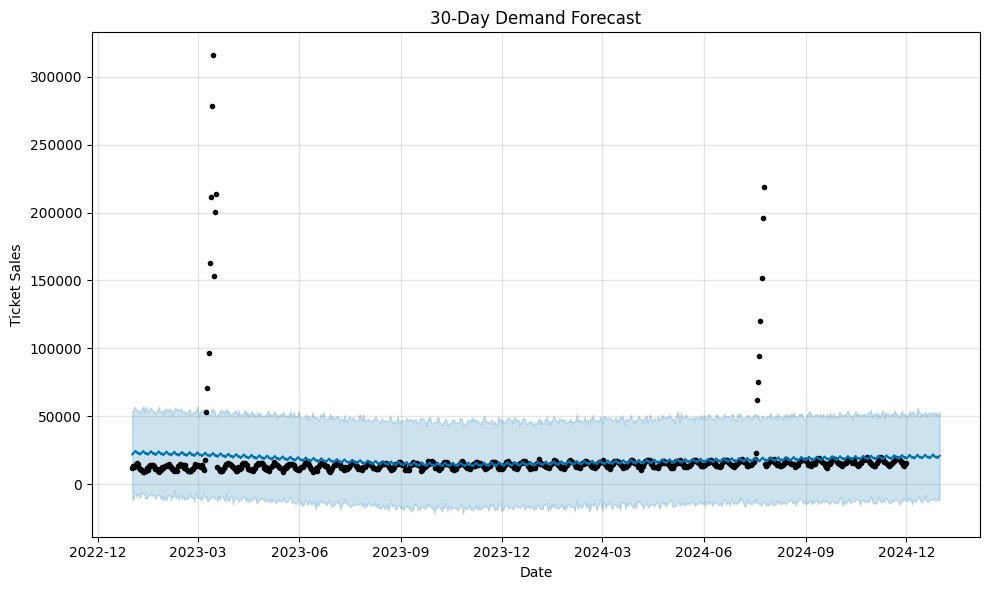

In [5]:
# phase4_forecast.py
# Demand Forecasting - 30 Day Ahead
# Uses Prophet to forecast ticket sales aggregated daily
# Generates PDF report with charts and metrics

import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from fpdf import FPDF
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import os

# --------- SETTINGS ---------
INPUT_CSV = "forecast_time_series_data.csv"  # Change to full path if needed
OUTPUT_FOLDER = "output"
FORECAST_DAYS = 30
# ----------------------------

# Ensure output folder exists
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# Load and prepare data
df = pd.read_csv(INPUT_CSV)
df['timestamp'] = pd.to_datetime(df['timestamp'])
# Aggregate hourly to daily totals
df_daily = df.groupby(df['timestamp'].dt.date)['ticket_sales'].sum().reset_index()
df_daily.columns = ['ds', 'y']
df_daily['ds'] = pd.to_datetime(df_daily['ds'])

# Train-test split (last 30 days as test)
train = df_daily[:-FORECAST_DAYS]
test = df_daily[-FORECAST_DAYS:]

# Fit Prophet model
model = Prophet()
model.fit(train)

# Forecast
future = model.make_future_dataframe(periods=FORECAST_DAYS)
forecast = model.predict(future)

# Merge with actuals for comparison
forecast_vs_actual = forecast[['ds', 'yhat']].merge(df_daily, on='ds', how='left')

# Calculate accuracy metrics on test period
test_forecast = forecast_vs_actual.tail(FORECAST_DAYS)
mae = mean_absolute_error(test['y'], test_forecast['yhat'])
rmse = np.sqrt(mean_squared_error(test['y'], test_forecast['yhat']))

# Plot forecast
fig1 = model.plot(forecast)
plt.title("30-Day Demand Forecast")
plt.xlabel("Date")
plt.ylabel("Ticket Sales")
plt.tight_layout()
forecast_chart_path = os.path.join(OUTPUT_FOLDER, "forecast_chart.png")
fig1.savefig(forecast_chart_path)

# Plot forecast vs actual
plt.figure(figsize=(10, 6))
plt.plot(train['ds'], train['y'], label='Train')
plt.plot(test['ds'], test['y'], label='Actual')
plt.plot(test_forecast['ds'], test_forecast['yhat'], label='Forecast')
plt.legend()
plt.title("Forecast vs Actual - Last 30 Days")
plt.xlabel("Date")
plt.ylabel("Ticket Sales")
plt.tight_layout()
comparison_chart_path = os.path.join(OUTPUT_FOLDER, "forecast_vs_actual.png")
plt.savefig(comparison_chart_path)
plt.close()

# Create PDF report
pdf = FPDF()
pdf.add_page()
pdf.set_font("Arial", 'B', 16)
pdf.cell(0, 10, "Demand Forecast Report - 30 Day Forecast", ln=1, align="C")

pdf.set_font("Arial", '', 12)
pdf.ln(5)
pdf.multi_cell(0, 8, 
    f"This report shows the forecasted ticket sales for the next {FORECAST_DAYS} days "
    f"based on historical data. The model used is Facebook Prophet, trained on daily "
    f"aggregated sales. We also compare the forecast with actual sales over the last 30 days."
)

pdf.ln(5)
pdf.cell(0, 8, f"Mean Absolute Error (MAE): {mae:.2f}", ln=1)
pdf.cell(0, 8, f"Root Mean Squared Error (RMSE): {rmse:.2f}", ln=1)

pdf.ln(5)
pdf.cell(0, 8, "Forecast Chart:", ln=1)
pdf.image(forecast_chart_path, w=170)

pdf.ln(5)
pdf.cell(0, 8, "Forecast vs Actual (Last 30 Days):", ln=1)
pdf.image(comparison_chart_path, w=170)

# Save PDF
pdf_path = os.path.join(OUTPUT_FOLDER, "Demand_Forecast_Report.pdf")
pdf.output(pdf_path)

print(f"Report generated: {pdf_path}")
print(f"Charts saved: {forecast_chart_path}, {comparison_chart_path}")
